#### Importing modules

In [1]:
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import graphviz

#### Decision Tree's Node class

In [2]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.right = right
        self.left = left
        self.value = value

# Method to check whether it is a leaf node
    def is_leaf_node(self):
        return self.value is not None

#### Decision Tree class

In [3]:
class DecisionTree:
    # Constructor
    def __init__(self, max_depth=2, min_samples=10, crit='gini'):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.tree = None
        self.crit = crit
    
    # Fit method
    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    # Predict method
    def predict(self, X):
        return np.array([self.predict_sample(x, self.tree) for x in X])
  
    # Entropy criterion
    def entropy(self, y):
        probas = (np.bincount(y) / y.shape[0])[1:]
        return -np.sum([prob*np.log(prob) for prob in probas if prob != 0])
        
    # Gini criterion 
    def gini(self, y):
        probas = (np.bincount(y) / y.shape[0])[1:]
        return np.sum([prob*(1-prob) for prob in probas])

    # Get most frequent class in a dataset
    def get_most_frequent_target(self, y):
        return np.argmax(np.bincount(y))

    # Find best parameters for a split
    def get_best_split(self, X, y):
        best_feature, best_threshold = 0, 0
        best_gain = -1
        for i in range(X.shape[1]):
            thresholds = np.unique(X[:, i])
            for threshold in thresholds:
                gain = self.get_information_gain(X[:, i], y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = i
                    best_threshold = threshold
        return best_feature, best_threshold

    # Method to evaluate information gain
    def get_information_gain(self, X_column, y, threshold):
        if len(np.unique(y)) == 1: return 0
        n = len(y)
        parent = self.gini(y) if self.crit == 'gini' else self.entropy(y)
        left_indexes = np.argwhere(X_column <= threshold).flatten()
        right_indexes = np.argwhere(X_column > threshold).flatten()
        crit_left = self.gini(y[left_indexes]) if self.crit == 'gini' else self.entropy(y[left_indexes])
        n_left = len(left_indexes)
        crit_right = self.gini(y[right_indexes]) if self.crit == 'gini' else self.entropy(y[right_indexes])
        n_right = len(right_indexes)
        child = (n_left / n) * crit_left + (n_right / n) * crit_right
        return parent - child

    # Building tree
    def build_tree(self, X, y, depth=0):
        n_samples = len(y)
        n_labels = len(np.unique(y))
        
        # Если очередной узел является конечным
        if n_labels == 1 or depth >= self.max_depth or n_samples <= self.min_samples:
            return Node(value=self.get_most_frequent_target(y))
        
        best_feature, best_threshold = self.get_best_split(X, y)
        left_indexes = np.argwhere(X[:, best_feature] <= best_threshold).flatten()
        right_indexes = np.argwhere(X[:, best_feature] > best_threshold).flatten()
        left, right = 0, 0
        if len(left_indexes)!=0: left = self.build_tree(X[left_indexes, :], y[left_indexes], depth+1)
        if len(right_indexes)!=0: right = self.build_tree(X[right_indexes, :], y[right_indexes], depth+1)
        return Node(best_feature, best_threshold, left, right)

    # Predict method (for one sample)
    def predict_sample(self, x, tree):
        if tree.is_leaf_node(): return tree.value
        if x[tree.feature] > tree.threshold: return self.predict_sample(x, tree.right)
        return self.predict_sample(x, tree.left)

In [4]:
# Vizualize tree with graphviz
def get_graphviz_tree(clf, feature_names, target_names=None):
    dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=feature_names,  
                      class_names=target_names,  
                      filled=True, rounded=True,  
                      special_characters=True)  
    graph = graphviz.Source(dot_data)  
    return graph

In [5]:
datasets = {'Iris': load_iris(), 'Digits': load_digits(), 'Wine': load_wine(), 'Cancer': load_breast_cancer()}

In [6]:
models = {'Iris': dict(), 'Digits': dict(), 'Wine': dict(), 'Cancer': dict()}

In [7]:
# Dataframe for classifiction accuracy
df = pd.DataFrame({'Dataset': datasets.keys(), 'manual-gini': [None for name in datasets], 'manual-entropy': [None for name in datasets],
                  'sklearn-gini': [None for name in datasets], 'sklearn-entropy': [None for name in datasets]})
df = df.set_index('Dataset')

In [8]:
for name, dataset in datasets.items():
    X, y = dataset['data'], dataset['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)
    
    # Manual classifier with gini criterion
    my_clf_gini = DecisionTree(crit='gini', max_depth=10)
    my_clf_gini.fit(X_train, y_train)
    y_pred = my_clf_gini.predict(X_test)
    df['manual-gini'][name] = accuracy_score(y_pred, y_test) * 100
    
    # Manual classifier with entropy criterion
    my_clf_entropy = DecisionTree(crit='entropy', max_depth=10)
    my_clf_entropy.fit(X_train, y_train)
    y_pred = my_clf_entropy.predict(X_test)
    df['manual-entropy'][name] = accuracy_score(y_pred, y_test) * 100
    
    # SKlearn classifier with gini criterion
    sklearn_clf_gini = tree.DecisionTreeClassifier(criterion='gini', max_depth=10)
    sklearn_clf_gini.fit(X_train, y_train)
    y_pred = sklearn_clf_gini.predict(X_test)
    df['sklearn-gini'][name] = accuracy_score(y_pred, y_test) * 100
    models[name]['gini'] = sklearn_clf_gini
    
    # Manual classifier with entropy criterion
    sklearn_clf_entropy = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10)
    sklearn_clf_entropy.fit(X_train, y_train)
    y_pred = sklearn_clf_entropy.predict(X_test)
    df['sklearn-entropy'][name] = accuracy_score(y_pred, y_test) * 100
    models[name]['entropy'] = sklearn_clf_entropy

In [9]:
df.style.set_caption("Decision Tree")

,manual-gini,manual-entropy,sklearn-gini,sklearn-entropy
Dataset,,,,
Iris,96.666667,96.666667,95.000000,95.000000
Digits,81.502086,79.137691,80.389430,85.813630
Wine,88.888889,87.500000,87.500000,91.666667
Cancer,93.859649,92.543860,94.736842,92.982456


### Visualize Trees

#### Iris, gini

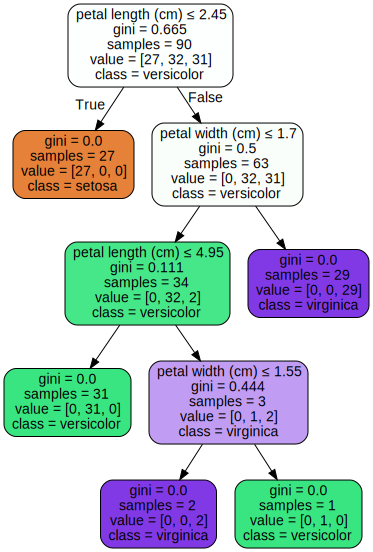

In [10]:
gr_tree = get_graphviz_tree(models['Iris']['gini'], datasets['Iris'].feature_names, datasets['Iris'].target_names)
gr_tree

#### Iris, entropy

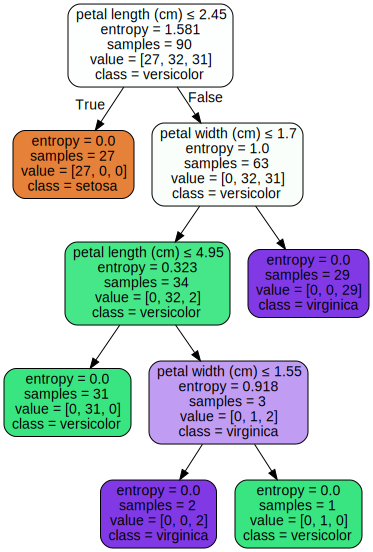

In [11]:
gr_tree = get_graphviz_tree(models['Iris']['entropy'], datasets['Iris'].feature_names, datasets['Iris'].target_names)
gr_tree

#### Digits, gini

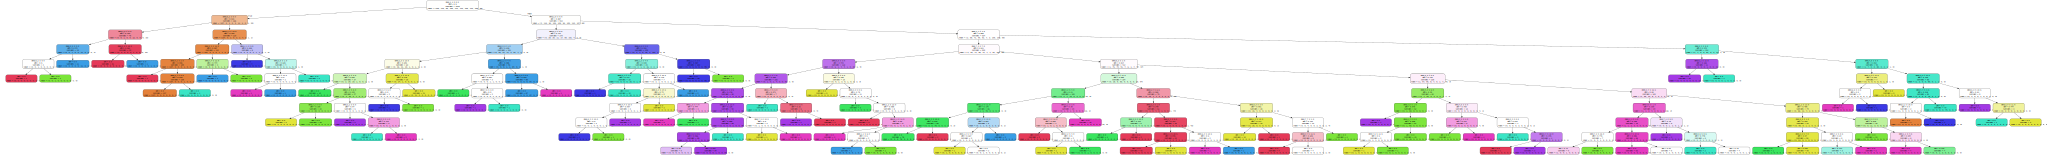

In [12]:
gr_tree = get_graphviz_tree(models['Digits']['gini'], datasets['Digits'].feature_names)
gr_tree

#### Digits, entropy

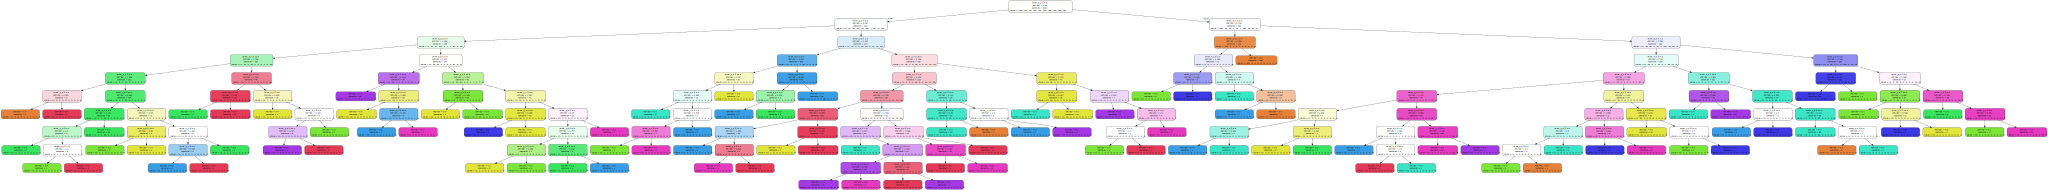

In [13]:
gr_tree = get_graphviz_tree(models['Digits']['entropy'], datasets['Digits'].feature_names)
gr_tree

#### Wine, gini

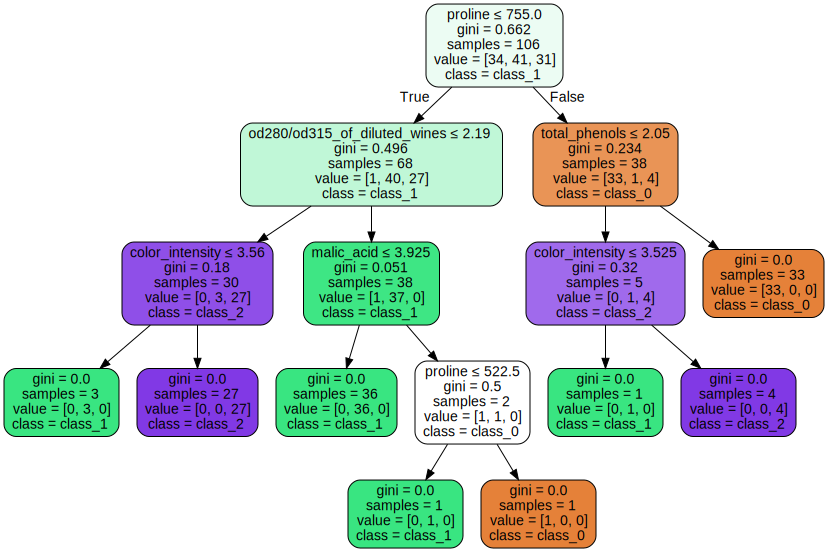

In [14]:
gr_tree = get_graphviz_tree(models['Wine']['gini'], datasets['Wine'].feature_names, datasets['Wine'].target_names)
gr_tree

#### Wine, entropy

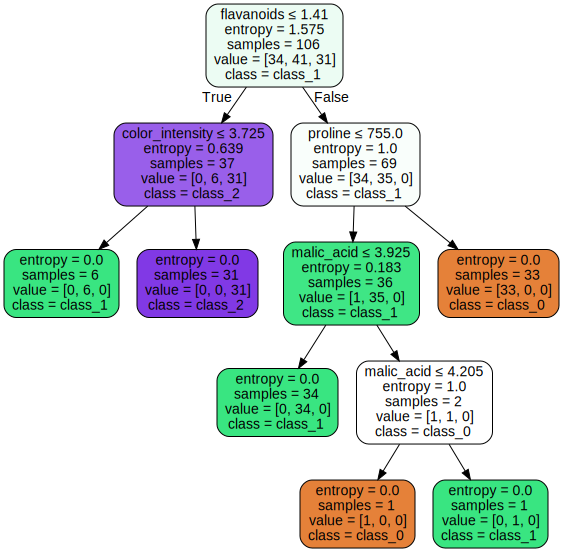

In [15]:
gr_tree = get_graphviz_tree(models['Wine']['entropy'], datasets['Wine'].feature_names, datasets['Wine'].target_names)
gr_tree

#### Cancer, gini

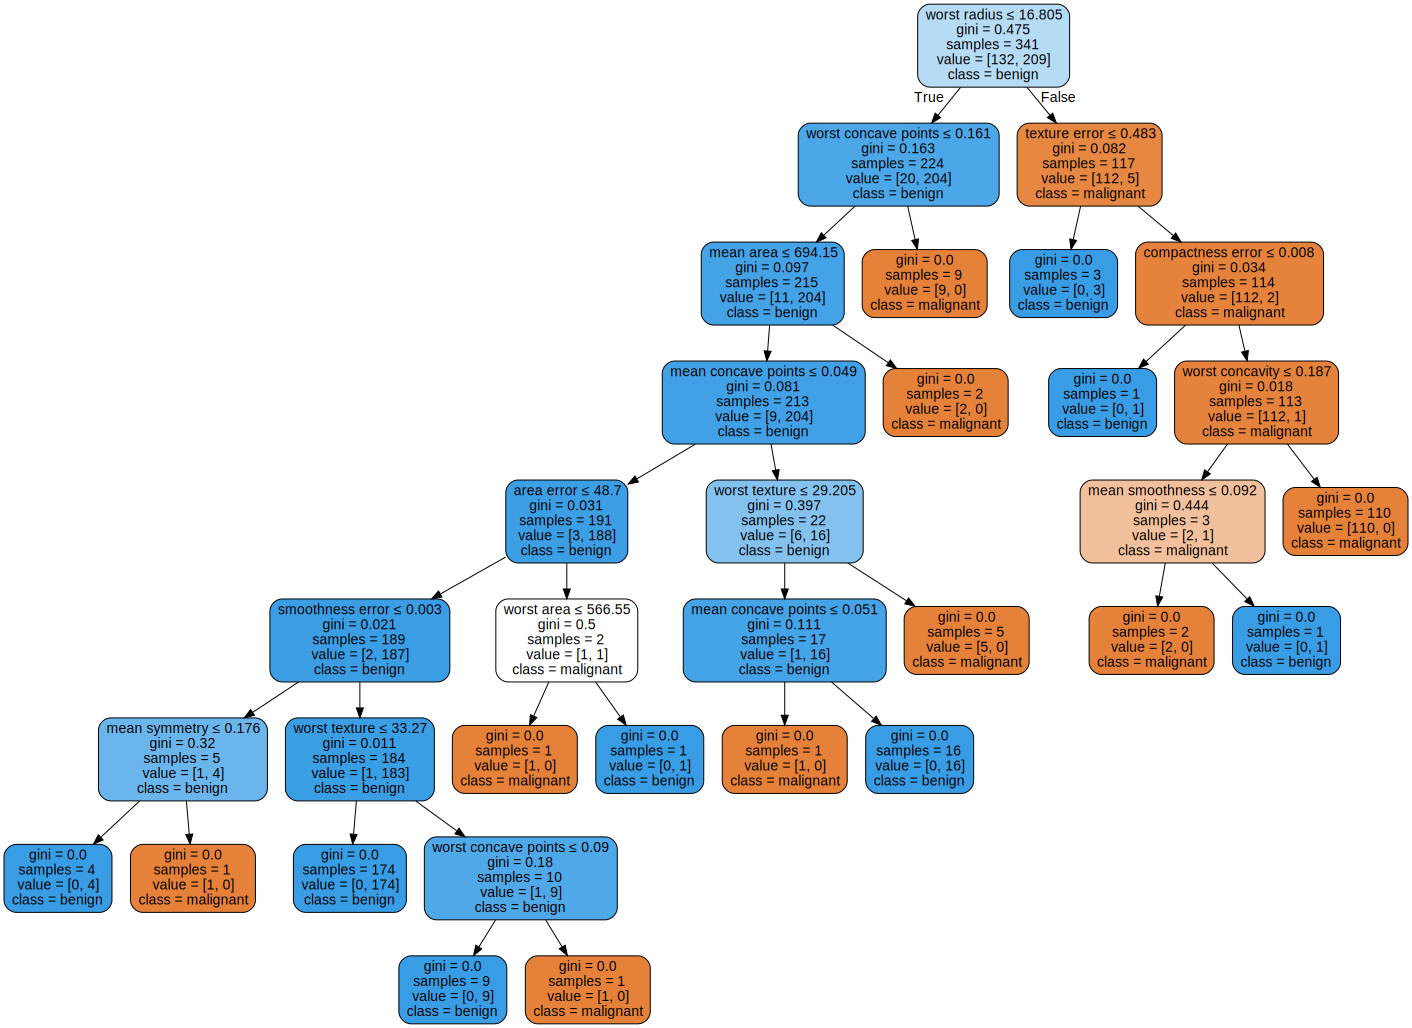

In [16]:
gr_tree = get_graphviz_tree(models['Cancer']['gini'], datasets['Cancer'].feature_names, datasets['Cancer'].target_names)
gr_tree

#### Cancer, entropy

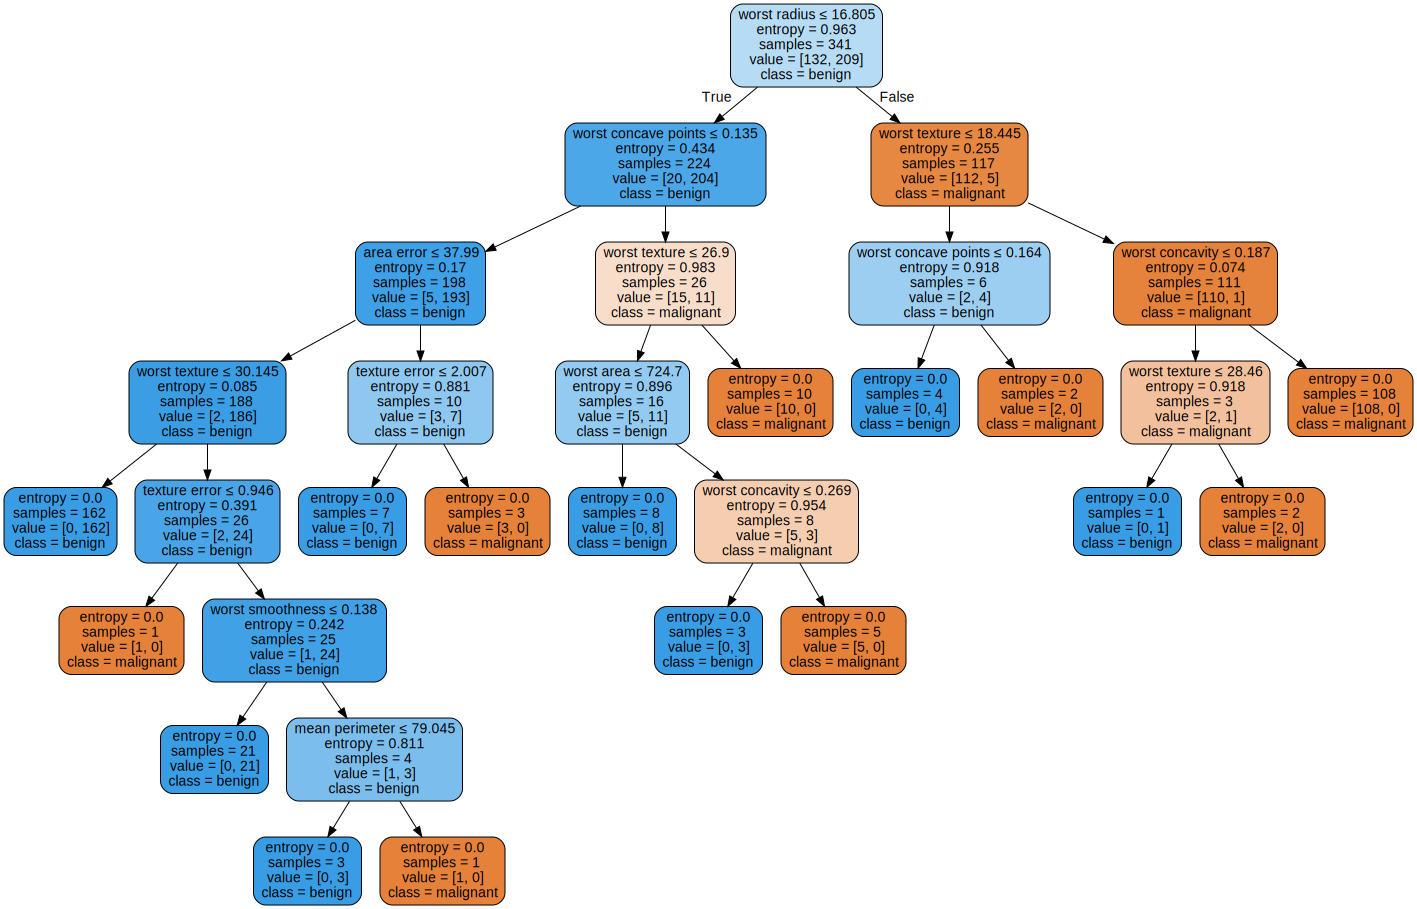

In [17]:
gr_tree = get_graphviz_tree(models['Cancer']['entropy'], datasets['Cancer'].feature_names, datasets['Cancer'].target_names)
gr_tree